In [1]:
chunk_size = 100
novel_to_analyze = 'Desperate Remedies.txt'

In [2]:
import codecs
import os
import pandas as pd
# to be able to see more columns when dataframes are printed out:
pd.set_option('display.max_columns', 100)
# to not get copy warnings when splitting dataframes
pd.options.mode.chained_assignment = None
import re
import spacy
import sys
import numpy as np
import matplotlib.pyplot as plt
import random


In [3]:
## to Newpaper Novel corpus:
path_to_nnovels_corpus = '../../data/corpora/corpus_newspaper_novels/' 

## to assets:
path_to_assets = '../../assets/'
## characters and numbers to exclude from texts:
exclude_file = 'characters_and_numbers_to_exclude.txt'

# characters to exclude
with codecs.open(path_to_assets + exclude_file, 'r', encoding='utf-8', errors="ignore") as characters_to_exclude_raw:
    characters_to_exclude = characters_to_exclude_raw.read()
    characters_to_exclude = characters_to_exclude.split()

In [4]:
from nltk.tokenize import sent_tokenize

In [5]:
def clean_text_returns_sentences(text, characters_to_exclude=characters_to_exclude):
    # lowercasing the text
    text = text.lower()

    # removing all characters in characters_to_exclude
    text = ''.join(char for char in text if char not in characters_to_exclude)

    # replacing all newline '\n' with spaces
    text = text.replace('\n', " ")

    # replacing all multiple spaces with a single space
    text = re.sub('\s+',' ', text)
    text = re.sub('mr.','mister', text)
    print(text[:20])
    # getting list of sentences
    text_split_sentences = re.split(r"\.|\:|\?|\!", text)
    text_split_sentences.pop(0)
    # getting rid of empty elements in sentences
    text_split_sentences = list(filter(None, text_split_sentences))
    text_split_sentences_stripped = []
    
    for sentence in text_split_sentences:
        new_sentence = sentence.strip()
        text_split_sentences_stripped.append(new_sentence)
    text_split_sentences_stripped = list(filter(None, text_split_sentences_stripped))    
    return text_split_sentences_stripped

In [6]:
with codecs.open(path_to_nnovels_corpus + novel_to_analyze, 'r', encoding='utf-8', errors="ignore") as raw_text:
    dirty_text = raw_text.read()

split_on = ["END OF THE PROJECT GUTENBERG","End of the Project Gutenberg EBook","End of Project Gutenberg","End of The Project Gutenberg"] 
for text in split_on:
    dirty_text = dirty_text.split(text)[0]

clean_text = sent_tokenize(dirty_text)
print(len(clean_text))
print(clean_text[:10])

6398
['\ufeffI.', 'THE EVENTS OF THIRTY YEARS\r\n\r\n1.', 'DECEMBER AND JANUARY, 1835-36\r\n\r\nIn the long and intricately inwrought chain of circumstance which\r\nrenders worthy of record some experiences of Cytherea Graye, Edward\r\nSpringrove, and others, the first event directly influencing the issue\r\nwas a Christmas visit.', 'In the above-mentioned year, 1835, Ambrose Graye, a young architect who\r\nhad just begun the practice of his profession in the midland town of\r\nHocbridge, to the north of Christminster, went to London to spend the\r\nChristmas holidays with a friend who lived in Bloomsbury.', 'They had\r\ngone up to Cambridge in the same year, and, after graduating together,\r\nHuntway, the friend, had taken orders.', 'Graye was handsome, frank, and gentle.', 'He had a quality of thought\r\nwhich, exercised on homeliness, was humour; on nature, picturesqueness;\r\non abstractions, poetry.', 'Being, as a rule, broadcast, it was all three.', 'Of the wickedness of the worl

In [7]:
text_dict = {"sentences":clean_text}
df = pd.DataFrame.from_dict(text_dict)
df.head(10)

,sentences
0,﻿I.
1,THE EVENTS OF THIRTY YEARS\r\n\r\n1.
2,"DECEMBER AND JANUARY, 1835-36\r\n\r\nIn the lo..."
3,"In the above-mentioned year, 1835, Ambrose Gra..."
4,They had\r\ngone up to Cambridge in the same y...
5,"Graye was handsome, frank, and gentle."
6,"He had a quality of thought\r\nwhich, exercise..."
7,"Being, as a rule, broadcast, it was all three."
8,Of the wickedness of the world he was too forg...
9,To discover evil in\r\na new friend is to most...


In [8]:
df["sentence_length"] = 0
df["location"] = 0
location = 0
count = 0

for index, row in df.iterrows():
    if index % chunk_size == 0:
        location += 1
    df.at[index, "location"] = location
    df.at[index, "sentence_length"] = len(row["sentences"])
    

In [9]:
# for index, row in df.iterrows():
#     if len(row["sentences"]) < 4:
#         print(index)
#         print(row["sentences"])

In [10]:
df2 = df[df.sentence_length >= 3]    

In [11]:
# for index, row in df2.iterrows():
#     if len(row["sentences"]) < 4:
#         print(index)
#         print(row["sentences"])

In [12]:
## POS tagging:

def progress(count, total, status=''):
    bar_len = 60
    filled_len = int(round(bar_len * count / float(total)))
    percents = round(100.1 * count / float(total), 1)
    bar = '#' * filled_len + '-' * (bar_len - filled_len)
    sys.stdout.write('[%s] %s%s ...%s\r' % (bar, percents, '%', status))
    sys.stdout.flush() 
    
# first loading english language support
nlp = spacy.load("en_core_web_sm")

## Takes in a dataframe and clean text column (as string), and returns the df with POS tags for all the texts
## Multiple columns are created, one for each POS tag, and one that contains all POS tags (I did this to more easily
## be able to grab POS percentages afterward)
def get_POS_tags_for_text_in_df(df, text_row_to_analyze='sentences'):
    # setting up column for pos counts
    df['all_pos_counts'] = ''
    df["parts_of_speech_total_count"] = ''
    # loop through df and get all POS tags:
    for index, row in df.iterrows():
        # show progress
        progress(index, len(df.index))
        
        # grab text
        text = row[text_row_to_analyze]
        
        # this is a memory buffer, to extend max length of available ram according to the text being analyzed
        # https://datascience.stackexchange.com/questions/38745/increasing-spacy-max-nlp-limit
        nlp.max_length = len(text) + 100
        
        # disable modules not in use to save memory
        analyzed_doc = nlp(text, disable = ['ner'])
        
        # grabbing all pos counts in the text in non-human readable format
        pos_counts_in_text = analyzed_doc.count_by(spacy.attrs.IDS['POS'])
        
        # setting up list to render pos hashes in human readable format:
        human_readable_pos_count_list = []
        
        # iterating through counts to make hashes human readable:
        for pos, count in pos_counts_in_text.items():
            human_readable_tag = analyzed_doc.vocab[pos].text
            # rendering as list to input back into df
            human_readable_tag_and_count = list((human_readable_tag, count))
            human_readable_pos_count_list.append(human_readable_tag_and_count)
        # looping through the human readable counts, assigning their label to the column
        # and the count to the row for each pos tag
        for element in human_readable_pos_count_list:
            df.at[index, 'POS_' + str(element[0])+'_count'] = element[1]
        
        # placing all the pos counts for each text in the all_pos_counts column
        df.at[index, 'all_pos_counts'] = human_readable_pos_count_list
        
        
    df = df.fillna(0)
    # getting POS percentages for each POS tag in texts
    # There are much easier and more efficient ways to do this rather than looping over the entire df again but we were pressed for time...
    # TODO: integrate this loop into previous loop
    for index, row in df.iterrows():
        total = 0.0
        for name in df.columns.values.tolist():
            if name.startswith("POS_"):
                # get total POS elements count for sanity
                total += row[name]
        try:
            df.at[index, "parts_of_speech_total_count"] = int(total)
        except Exception as e:
            print(e)
        for name in df.columns.values.tolist():
            if name.startswith("POS_"):
                # assign new name for column
                new_name = "%" + name
                # get % of total POS in text
                if total != 0:
                    percentage = round((row[name] / total) * float(100), 3)
                else:
                    print(row[text_row_to_analyze])
                # if this is the first index, create the column name to avoid errors
                if index == 0:
                    df[new_name] = 0.0
                df.at[index, new_name] = percentage
    return df

In [13]:
rows_where_total_is_zero = []
df2 = get_POS_tags_for_text_in_df(df2, text_row_to_analyze='sentences')
df2.head(10)

,sentences,sentence_length,location,all_pos_counts,parts_of_speech_total_count,POS_NOUN_count,POS_DET_count,POS_ADP_count,POS_PROPN_count,POS_SPACE_count,POS_NUM_count,POS_PUNCT_count,POS_CCONJ_count,POS_SYM_count,POS_ADJ_count,POS_ADV_count,POS_PRON_count,POS_VERB_count,POS_AUX_count,POS_PART_count,POS_SCONJ_count,POS_INTJ_count,POS_X_count,%POS_NOUN_count,%POS_DET_count,%POS_ADP_count,%POS_PROPN_count,%POS_SPACE_count,%POS_NUM_count,%POS_PUNCT_count,%POS_CCONJ_count,%POS_SYM_count,%POS_ADJ_count,%POS_ADV_count,%POS_PRON_count,%POS_VERB_count,%POS_AUX_count,%POS_PART_count,%POS_SCONJ_count,%POS_INTJ_count,%POS_X_count
0,﻿I.,3,1,"[[NOUN, 1]]",1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.0
1,THE EVENTS OF THIRTY YEARS\r\n\r\n1.,32,1,"[[DET, 1], [NOUN, 2], [ADP, 1], [PROPN, 1], [S...",8,2.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.000,12.500,12.500,12.500,12.500,12.500,12.500,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.0
2,"DECEMBER AND JANUARY, 1835-36\r\n\r\nIn the lo...",263,1,"[[PROPN, 7], [CCONJ, 3], [PUNCT, 5], [NUM, 2],...",49,9.0,5.0,4.0,7.0,4.0,2.0,5.0,3.0,1.0,4.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,18.367,10.204,8.163,14.286,8.163,4.082,10.204,6.122,2.041,8.163,4.082,2.041,2.041,2.041,0.000,0.0,0.0,0.0
3,"In the above-mentioned year, 1835, Ambrose Gra...",271,1,"[[ADP, 9], [DET, 7], [ADV, 2], [PUNCT, 7], [VE...",56,8.0,7.0,9.0,8.0,3.0,1.0,7.0,0.0,0.0,1.0,2.0,3.0,5.0,1.0,1.0,0.0,0.0,0.0,14.286,12.500,16.071,14.286,5.357,1.786,12.500,0.000,0.000,1.786,3.571,5.357,8.929,1.786,1.786,0.0,0.0,0.0
4,They had\r\ngone up to Cambridge in the same y...,120,1,"[[PRON, 1], [VERB, 4], [SPACE, 2], [ADP, 4], [...",28,3.0,2.0,4.0,2.0,2.0,0.0,6.0,1.0,0.0,1.0,1.0,1.0,4.0,1.0,0.0,0.0,0.0,0.0,10.714,7.143,14.286,7.143,7.143,0.000,21.429,3.571,0.000,3.571,3.571,3.571,14.286,3.571,0.000,0.0,0.0,0.0
5,"Graye was handsome, frank, and gentle.",38,1,"[[PROPN, 1], [AUX, 1], [ADJ, 3], [PUNCT, 3], [...",9,0.0,0.0,0.0,1.0,0.0,0.0,3.0,1.0,0.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,11.111,0.000,0.000,33.333,11.111,0.000,33.333,0.000,0.000,0.000,11.111,0.000,0.0,0.0,0.0
6,"He had a quality of thought\r\nwhich, exercise...",126,1,"[[PRON, 2], [VERB, 2], [DET, 1], [NOUN, 7], [A...",27,7.0,1.0,4.0,1.0,2.0,0.0,7.0,0.0,0.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,25.926,3.704,14.815,3.704,7.407,0.000,25.926,0.000,0.000,0.000,0.000,7.407,7.407,3.704,0.000,0.0,0.0,0.0
7,"Being, as a rule, broadcast, it was all three.",46,1,"[[AUX, 2], [PUNCT, 4], [ADP, 1], [DET, 1], [NO...",13,2.0,1.0,1.0,0.0,0.0,1.0,4.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,15.385,7.692,7.692,0.000,0.000,7.692,30.769,0.000,0.000,0.000,0.000,15.385,0.000,15.385,0.000,0.0,0.0,0.0
8,Of the wickedness of the world he was too forg...,52,1,"[[ADP, 2], [DET, 2], [NOUN, 2], [PRON, 1], [AU...",11,2.0,2.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,18.182,18.182,18.182,0.000,0.000,0.000,9.091,0.000,0.000,9.091,9.091,9.091,0.000,9.091,0.000,0.0,0.0,0.0
9,To discover evil in\r\na new friend is to most...,114,1,"[[PART, 1], [VERB, 1], [NOUN, 5], [ADP, 3], [S...",26,5.0,3.0,3.0,0.0,2.0,0.0,2.0,0.0,0.0,3.0,2.0,2.0,1.0,2.0,1.0,0.0,0.0,0.0,19.231,11.538,11.538,0.000,7.692,0.000,7.692,0.000,0.000,11.538,7.692,7.692,3.846,7.692,3.846,0.0,0.0,0.0


In [14]:
### FUNCTIONS 2/3

## This function takes in a list of dataframes, a list of columns to visualize, and a date column (with the same name in both dataframes)
## then plots those columns over time.

def visualize_numerical_columns__over_time(dfs, list_of_columns_to_visualize, date_column='location', graph_y_label='What are we counting?', title='SOMETHING over the novel'):
    # Setting lists to capture the elements for visualization
    years_list = []
    counts_list = []
    labels_list = []
    colors_list = []
    
    # lazy way to grab some relevant info to have comparison points when looking at visuals
    print_info = []
    
    # the first dataframe in the list will be "DF_0", the second "DF_1", and so on.
    # in our case, DF_0 == df_nnovels_meta and DF_1 == df_txtlab_meta
    which_df = 0
    # loops for each df in list
    for df in dfs:
        # loops for each column in list
        for column_name in list_of_columns_to_visualize:
            
            # first grouping the specific column by year
            grouped_by_year = pd.to_numeric(df[column_name]).groupby(df[date_column])
            grouped_by_year = grouped_by_year.mean().reset_index()
            
            # grabbing the array of the years 
            years = np.array(grouped_by_year[date_column].tolist())
            # grabbing the array of the column we're visualizing
            count_to_visualize = np.array(grouped_by_year[column_name].tolist())
            
            # placing these elements in a list, and grabbing a label to know which DF is which
            years_list.append(years)
            counts_list.append(count_to_visualize)
            labels_list.append("DF_"+ str(which_df) +"_"+ column_name)
            
            # getting random colors to visualize
            r = random.random()
            b = random.random()
            g = random.random()
            color = (r, g, b)
            colors_list.append(color)
            
            # lazy way to add additional info 
            print_info.append(["The AVG of " + column_name + " of DF_" + str(which_df) +" is "+ str(df[column_name].mean())])
            print_info.append(["The MIN of " + column_name + " of DF_" + str(which_df) +" is "+ str(df[column_name].min())])
            print_info.append(["The MAX of " + column_name + " of DF_" + str(which_df) +" is "+ str(df[column_name].max())])
            
        # once loop finishes, increment DF number    
        which_df += 1
        
    # setting the size of the plot
    plt.figure(figsize=(20,10))
    # looping through the labels we added (essentially each DF), and plotting the elements sequentially using the index for each of the lists created above
    for index in range(len(labels_list)):
        plt.plot(years_list[index], counts_list[index], label=labels_list[index], c=colors_list[index])
    # showing the plot    
    plt.legend(loc='upper left')
    plt.title(title)
    plt.show()
    
    # printing out supplementary info
    for info in print_info:
        print(info)
        
    return None

In [15]:
dfs = [df2]


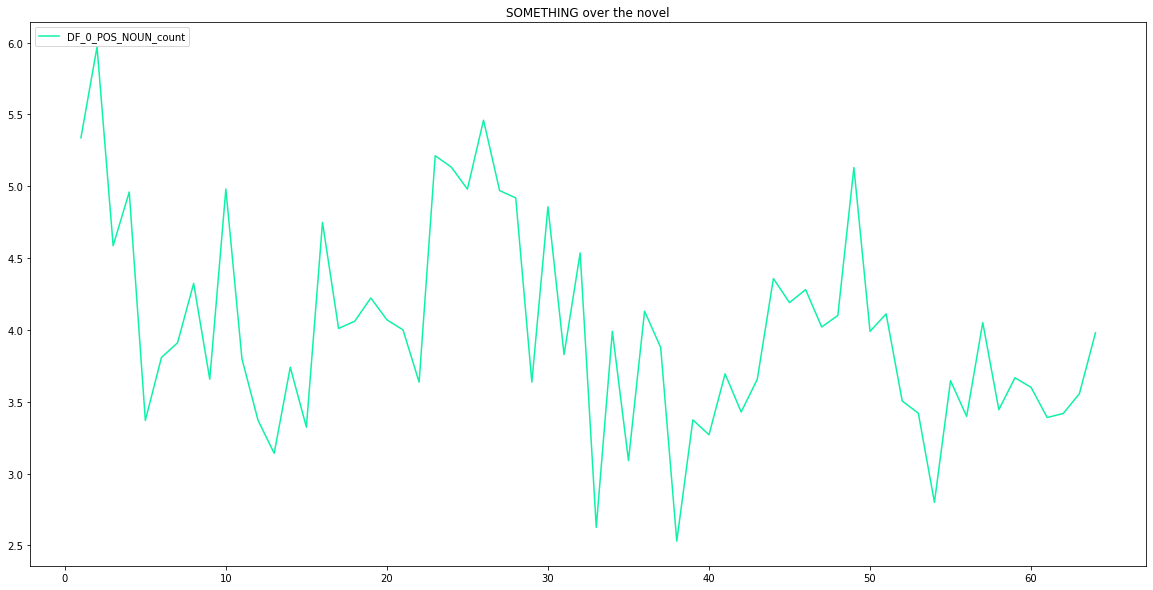

['The AVG of POS_NOUN_count of DF_0 is 4.002368545712932']
['The MIN of POS_NOUN_count of DF_0 is 0.0']
['The MAX of POS_NOUN_count of DF_0 is 36.0']


In [16]:
visualize_numerical_columns__over_time(dfs, ['POS_NOUN_count'], date_column='location', graph_y_label='What are we counting?', title='SOMETHING over the novel')

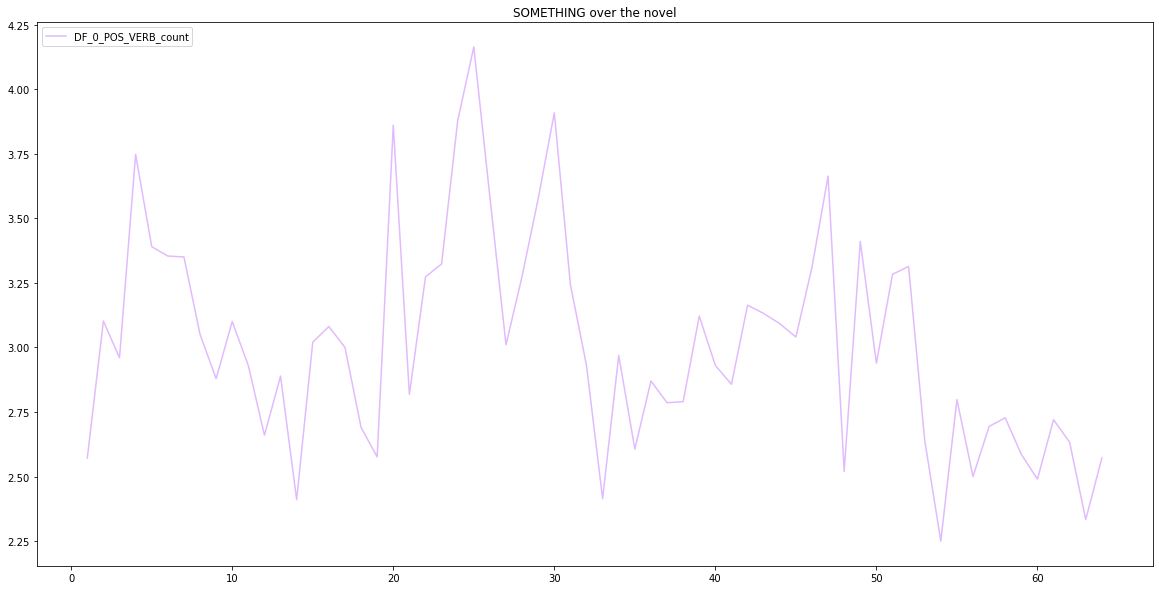

['The AVG of POS_VERB_count of DF_0 is 3.0110532133270174']
['The MIN of POS_VERB_count of DF_0 is 0.0']
['The MAX of POS_VERB_count of DF_0 is 23.0']


In [17]:
visualize_numerical_columns__over_time(dfs, ['POS_VERB_count'], date_column='location', graph_y_label='What are we counting?', title='SOMETHING over the novel')

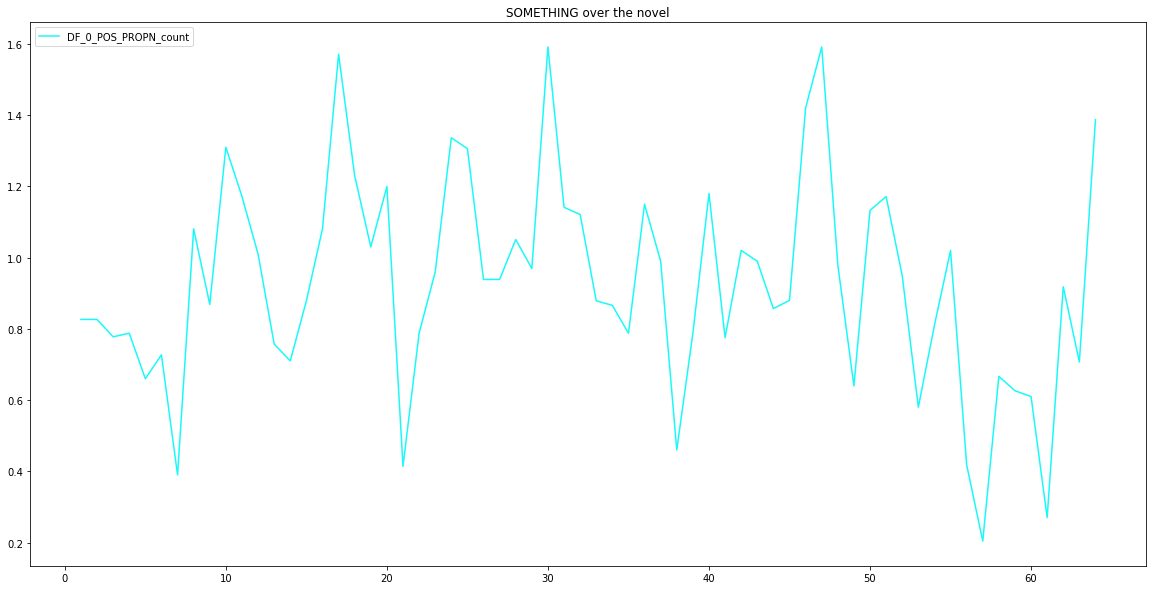

['The AVG of POS_PROPN_count of DF_0 is 0.9242065371861677']
['The MIN of POS_PROPN_count of DF_0 is 0.0']
['The MAX of POS_PROPN_count of DF_0 is 13.0']


In [18]:
visualize_numerical_columns__over_time(dfs, ['POS_PROPN_count'], date_column='location', graph_y_label='What are we counting?', title='SOMETHING over the novel')

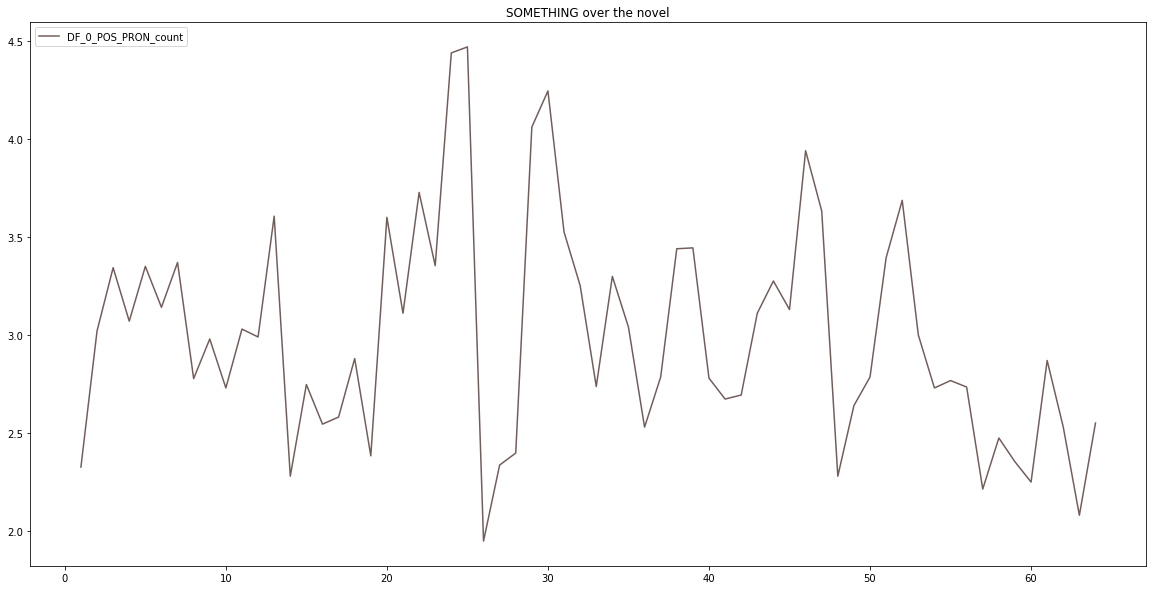

['The AVG of POS_PRON_count of DF_0 is 2.9917890415285013']
['The MIN of POS_PRON_count of DF_0 is 0.0']
['The MAX of POS_PRON_count of DF_0 is 25.0']


In [19]:
visualize_numerical_columns__over_time(dfs, ['POS_PRON_count'], date_column='location', graph_y_label='What are we counting?', title='SOMETHING over the novel')

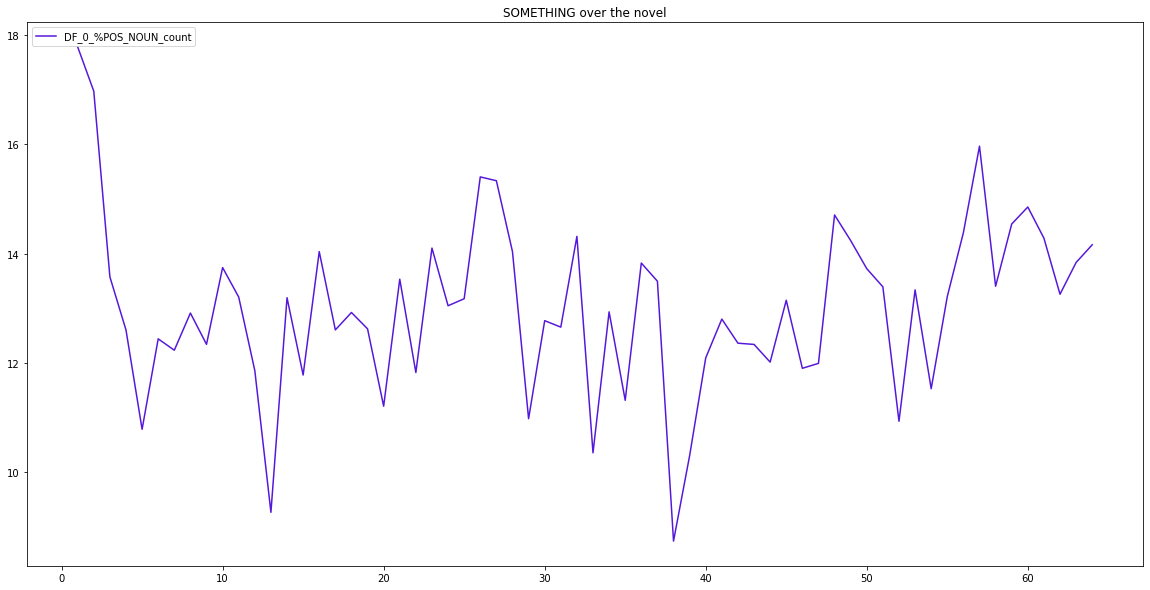

['The AVG of %POS_NOUN_count of DF_0 is 13.004324648665651']
['The MIN of %POS_NOUN_count of DF_0 is 0.0']
['The MAX of %POS_NOUN_count of DF_0 is 100.0']


In [20]:
visualize_numerical_columns__over_time(dfs, ['%POS_NOUN_count'], date_column='location', graph_y_label='What are we counting?', title='SOMETHING over the novel')

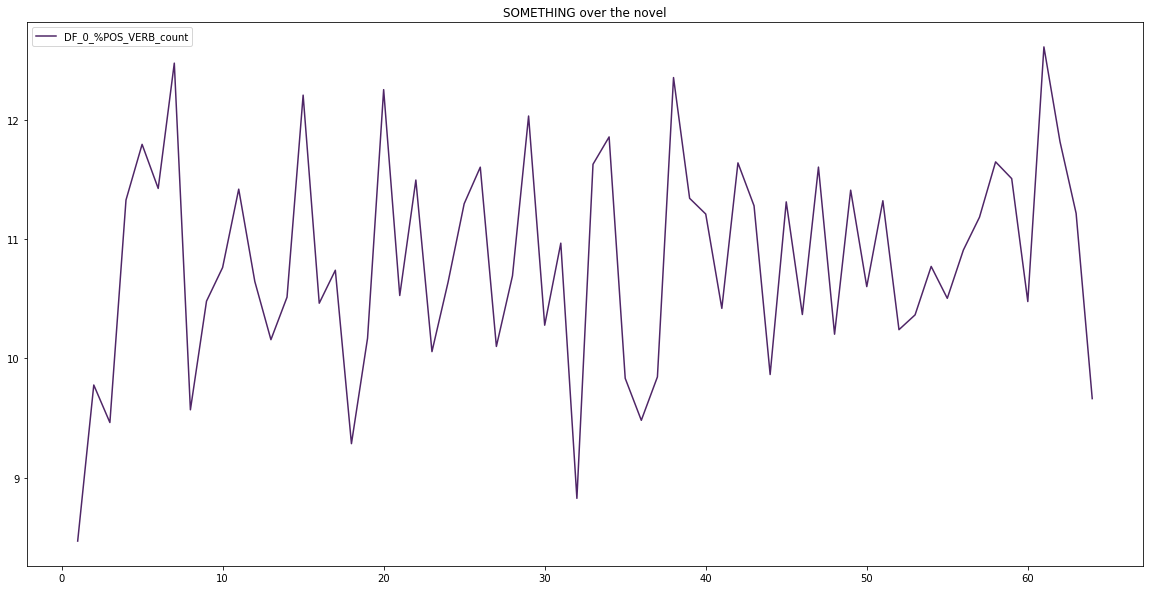

['The AVG of %POS_VERB_count of DF_0 is 10.819754460760983']
['The MIN of %POS_VERB_count of DF_0 is 0.0']
['The MAX of %POS_VERB_count of DF_0 is 50.0']


In [21]:
visualize_numerical_columns__over_time(dfs, ['%POS_VERB_count'], date_column='location', graph_y_label='What are we counting?', title='SOMETHING over the novel')

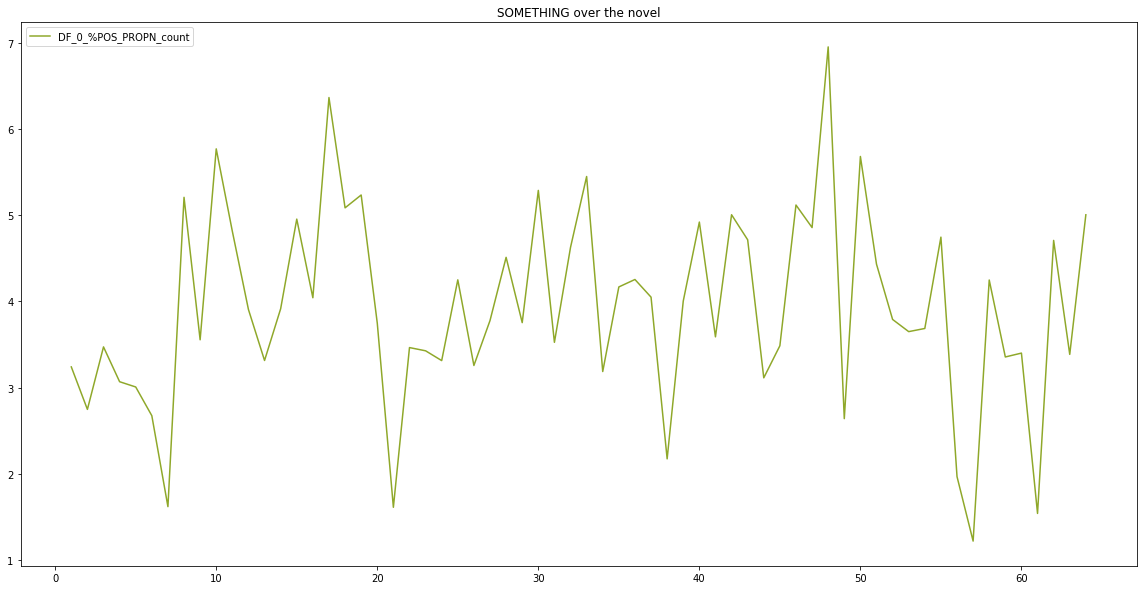

['The AVG of %POS_PROPN_count of DF_0 is 3.921279488394134']
['The MIN of %POS_PROPN_count of DF_0 is 0.0']
['The MAX of %POS_PROPN_count of DF_0 is 75.0']


In [22]:
visualize_numerical_columns__over_time(dfs, ['%POS_PROPN_count'], date_column='location', graph_y_label='What are we counting?', title='SOMETHING over the novel')

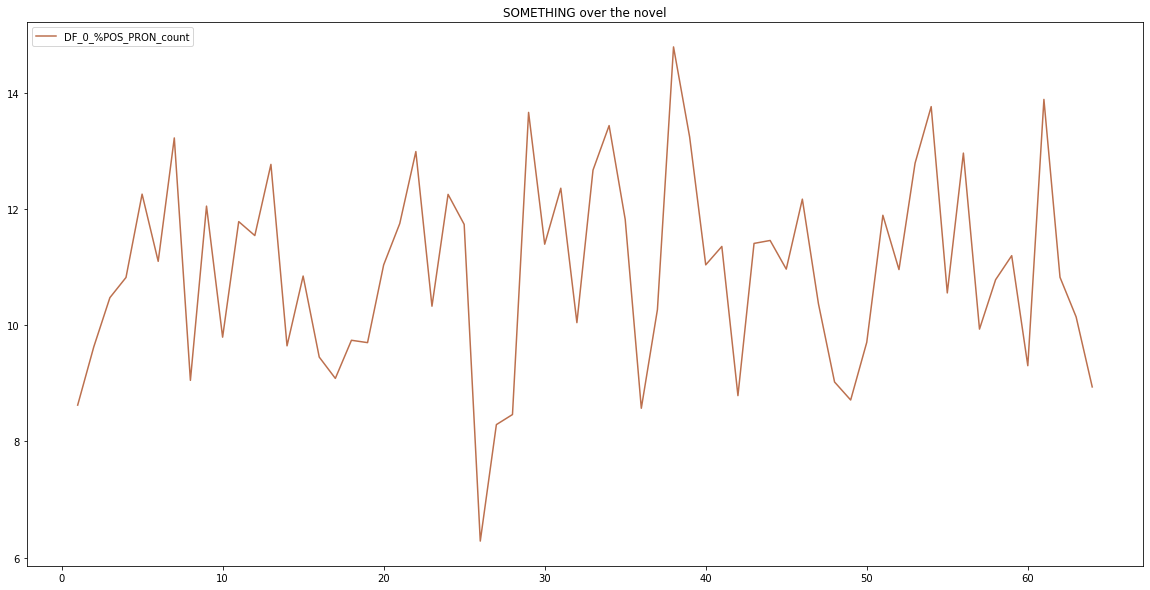

['The AVG of %POS_PRON_count of DF_0 is 10.935075793462769']
['The MIN of %POS_PRON_count of DF_0 is 0.0']
['The MAX of %POS_PRON_count of DF_0 is 50.0']


In [23]:
visualize_numerical_columns__over_time(dfs, ['%POS_PRON_count'], date_column='location', graph_y_label='What are we counting?', title='SOMETHING over the novel')

In [24]:
grouped_by_year = pd.to_numeric(df2['POS_NOUN_count']).groupby(df2['location'])
grouped_by_year.head(10)

0       1.0
1       2.0
2       9.0
3       8.0
4       3.0
       ... 
6305    2.0
6306    1.0
6307    0.0
6308    1.0
6309    9.0
Name: POS_NOUN_count, Length: 640, dtype: float64

In [25]:
grouped_by_year = grouped_by_year.mean().reset_index()
grouped_by_year.head()

,location,POS_NOUN_count
0,1,5.336735
1,2,5.969388
2,3,4.585859
3,4,4.959596
4,5,3.370000


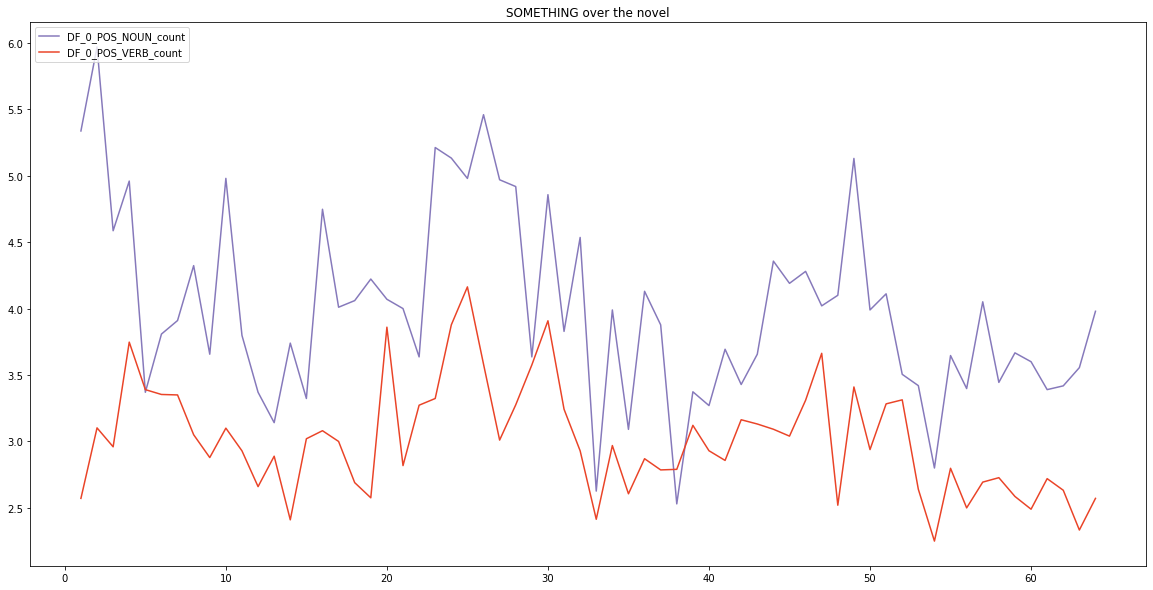

['The AVG of POS_NOUN_count of DF_0 is 4.002368545712932']
['The MIN of POS_NOUN_count of DF_0 is 0.0']
['The MAX of POS_NOUN_count of DF_0 is 36.0']
['The AVG of POS_VERB_count of DF_0 is 3.0110532133270174']
['The MIN of POS_VERB_count of DF_0 is 0.0']
['The MAX of POS_VERB_count of DF_0 is 23.0']


In [26]:
visualize_numerical_columns__over_time(dfs, ['POS_NOUN_count','POS_VERB_count',], date_column='location', graph_y_label='What are we counting?', title='SOMETHING over the novel')

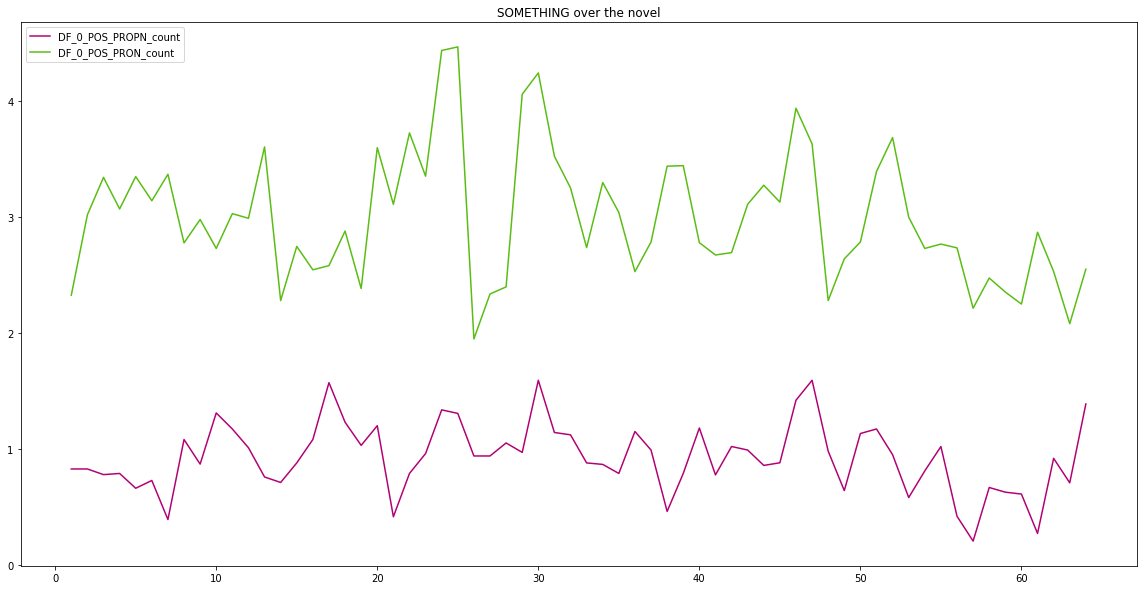

['The AVG of POS_PROPN_count of DF_0 is 0.9242065371861677']
['The MIN of POS_PROPN_count of DF_0 is 0.0']
['The MAX of POS_PROPN_count of DF_0 is 13.0']
['The AVG of POS_PRON_count of DF_0 is 2.9917890415285013']
['The MIN of POS_PRON_count of DF_0 is 0.0']
['The MAX of POS_PRON_count of DF_0 is 25.0']


In [27]:
visualize_numerical_columns__over_time(dfs, ['POS_PROPN_count','POS_PRON_count',], date_column='location', graph_y_label='What are we counting?', title='SOMETHING over the novel')

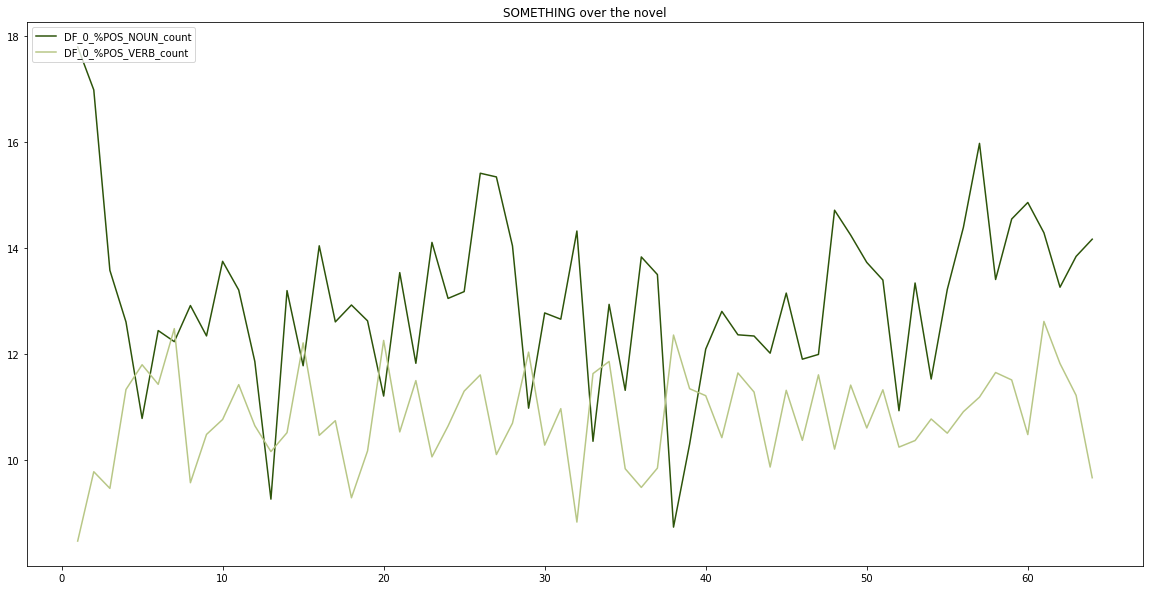

['The AVG of %POS_NOUN_count of DF_0 is 13.004324648665651']
['The MIN of %POS_NOUN_count of DF_0 is 0.0']
['The MAX of %POS_NOUN_count of DF_0 is 100.0']
['The AVG of %POS_VERB_count of DF_0 is 10.819754460760983']
['The MIN of %POS_VERB_count of DF_0 is 0.0']
['The MAX of %POS_VERB_count of DF_0 is 50.0']


In [28]:
visualize_numerical_columns__over_time(dfs, ['%POS_NOUN_count','%POS_VERB_count',], date_column='location', graph_y_label='What are we counting?', title='SOMETHING over the novel')

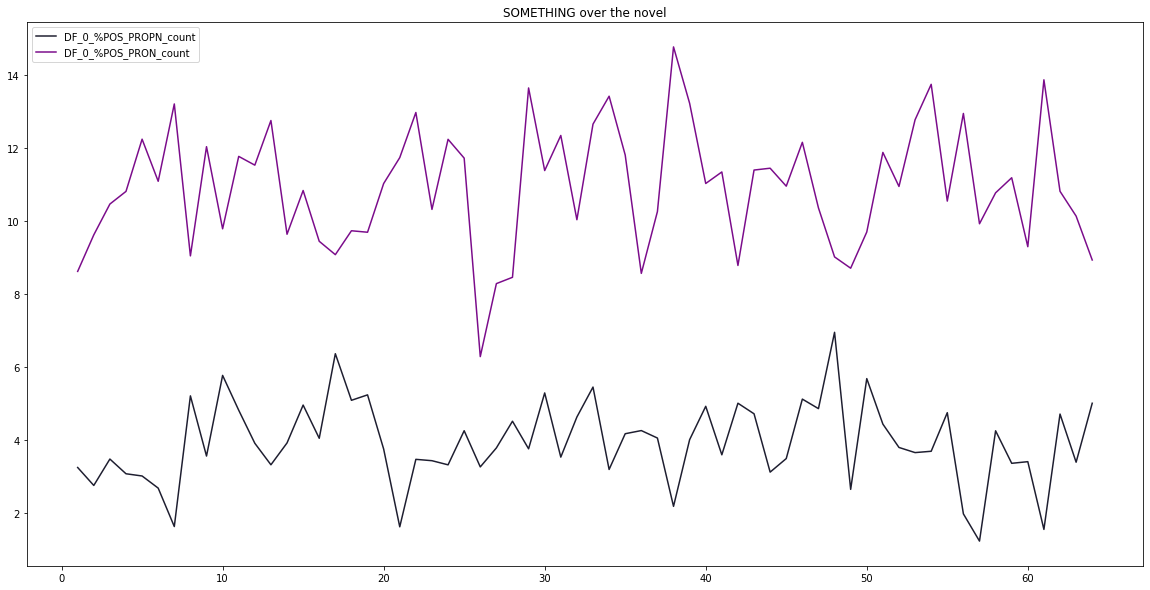

['The AVG of %POS_PROPN_count of DF_0 is 3.921279488394134']
['The MIN of %POS_PROPN_count of DF_0 is 0.0']
['The MAX of %POS_PROPN_count of DF_0 is 75.0']
['The AVG of %POS_PRON_count of DF_0 is 10.935075793462769']
['The MIN of %POS_PRON_count of DF_0 is 0.0']
['The MAX of %POS_PRON_count of DF_0 is 50.0']


In [29]:
visualize_numerical_columns__over_time(dfs, ['%POS_PROPN_count','%POS_PRON_count',], date_column='location', graph_y_label='What are we counting?', title='SOMETHING over the novel')

In [53]:
columns_in_df = df2.columns.values.tolist()
print(columns_in_df)

['sentences', 'sentence_length', 'location', 'all_pos_counts', 'parts_of_speech_total_count', 'POS_NOUN_count', 'POS_DET_count', 'POS_ADP_count', 'POS_PROPN_count', 'POS_SPACE_count', 'POS_NUM_count', 'POS_PUNCT_count', 'POS_CCONJ_count', 'POS_SYM_count', 'POS_ADJ_count', 'POS_ADV_count', 'POS_PRON_count', 'POS_VERB_count', 'POS_AUX_count', 'POS_PART_count', 'POS_SCONJ_count', 'POS_INTJ_count', 'POS_X_count', '%POS_NOUN_count', '%POS_DET_count', '%POS_ADP_count', '%POS_PROPN_count', '%POS_SPACE_count', '%POS_NUM_count', '%POS_PUNCT_count', '%POS_CCONJ_count', '%POS_SYM_count', '%POS_ADJ_count', '%POS_ADV_count', '%POS_PRON_count', '%POS_VERB_count', '%POS_AUX_count', '%POS_PART_count', '%POS_SCONJ_count', '%POS_INTJ_count', '%POS_X_count', 'text_section']


In [57]:
### Divide the DF into 5 sections and understand changes that happen in those sections:

list_of_elements_to_analyze = ['%POS_NOUN_count', '%POS_DET_count', '%POS_ADP_count', '%POS_PROPN_count', '%POS_ADJ_count', '%POS_ADV_count', '%POS_PRON_count', '%POS_VERB_count', '%POS_AUX_count']
N = 3
# columns_in_df = df2.columns.values.tolist()
print(f"Printing out information for {novel_to_analyze}. The DF is split into {N} sections.")
for name in list_of_elements_to_analyze:
    if name.startswith("%"):
        split_arrays = np.array_split(df2[name], N)
        print(f"The POS tag being shown is {name}.")
        for i in range(N):
            mean_of_section = split_arrays[i].mean()
            max_of_section = split_arrays[i].max()
            min_of_section = split_arrays[i].min()
            median_of_section = split_arrays[i].median()
            print(f"SECTION {i}: The MEAN value is: {mean_of_section}. The MAX value is: {max_of_section}. The MIN value is: {min_of_section}. The MEDIAN value is: {median_of_section}.")
# for array in split_arrays:
#     print(array)

Printing out information for Desperate Remedies.txt. The DF is split into 3 sections.
The POS tag being shown is %POS_NOUN_count.
SECTION 0: The MEAN value is: 12.895861676930378. The MAX value is: 100.0. The MIN value is: 0.0. The MEDIAN value is: 13.333.
SECTION 1: The MEAN value is: 12.646482235907188. The MAX value is: 50.0. The MIN value is: 0.0. The MEDIAN value is: 13.043.
SECTION 2: The MEAN value is: 13.470630033159672. The MAX value is: 66.667. The MIN value is: 0.0. The MEDIAN value is: 13.889.
The POS tag being shown is %POS_DET_count.
SECTION 0: The MEAN value is: 7.166189009947902. The MAX value is: 33.333. The MIN value is: 0.0. The MEDIAN value is: 7.059.
SECTION 1: The MEAN value is: 7.576628612032223. The MAX value is: 42.857. The MIN value is: 0.0. The MEDIAN value is: 7.317.
SECTION 2: The MEAN value is: 8.117664613927058. The MAX value is: 33.333. The MIN value is: 0.0. The MEDIAN value is: 8.108.
The POS tag being shown is %POS_ADP_count.
SECTION 0: The MEAN value